In [60]:
import numpy as np
np.set_printoptions(precision=5)

from scipy.linalg import block_diag
from scipy.integrate import ode
from scipy.optimize import minimize

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

from nengolib import Lowpass, DoubleExp
from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib.synapses import ss2sim
from nengolib.neurons import init_lif

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(context='poster', style='white')
%matplotlib inline

import warnings

## Neuron Types

In [7]:
class AdaptiveLIFT(LIFRate):
    
    '''
    Aaron Voelker
    https://github.com/nengo/nengo/issues/1423
    '''
    
    probeable = ('spikes', 'voltage', 'refractory_time', 'threshold')

    min_voltage = NumberParam('min_voltage', high=0)
    tau_adapt = NumberParam('tau_adapt', low=0)
    inc_adapt = NumberParam('inc_adapt', low=0)

    def __init__(self, tau_rc=0.02, tau_ref=0.002, min_voltage=0,
                 amplitude=1, tau_adapt=0.1, inc_adapt=0.05):
        super(AdaptiveLIFT, self).__init__(
            tau_rc=tau_rc, tau_ref=tau_ref, amplitude=amplitude)
        self.min_voltage = min_voltage
        self.tau_adapt = tau_adapt
        self.inc_adapt = inc_adapt
        
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = np.zeros_like(gain)
        refractory_time = np.zeros_like(gain)
        threshold = np.ones_like(gain)

        return settled_firingrate(
            self.step_math, J, [voltage, refractory_time, threshold],
            dt=0.001, settle_time=0.3, sim_time=1.0)
    
    def gain_bias(self, max_rates, intercepts):
        return NeuronType.gain_bias(self, max_rates, intercepts)

    def max_rates_intercepts(self, gain, bias):
        return NeuronType.max_rates_intercepts(self, gain, bias)

    def step_math(self, dt, J, spiked, voltage, refractory_time, threshold):
        # reduce all refractory times by dt
        refractory_time -= dt

        # compute effective dt for each neuron, based on remaining time.
        # note that refractory times that have completed midway into this
        # timestep will be given a partial timestep, and moreover these will
        # be subtracted to zero at the next timestep (or reset by a spike)
        delta_t = (dt - refractory_time).clip(0, dt)

        # update voltage using discretized lowpass filter
        # since v(t) = v(0) + (J - v(0))*(1 - exp(-t/tau)) assuming
        # J is constant over the interval [t, t + dt)
        voltage -= (J - voltage) * np.expm1(-delta_t / self.tau_rc)

        # determine which neurons spiked (set them to 1/dt, else 0)
        spiked_mask = voltage > threshold
        spiked[:] = spiked_mask * (self.amplitude / dt)

        # set v(0) = threshold and solve for t to compute the spike time
        # TODO: not sure if this mask is the right way to handle log domain errors
        threshold_spiked = threshold[spiked_mask]
        m = (voltage[spiked_mask] - threshold_spiked) / (J[spiked_mask] - threshold_spiked)
        t_spike = np.zeros_like(m)
        t_spike[m < 1] = dt + self.tau_rc * np.log1p(-m[m < 1])

        # update threshold using discretized lowpass filter
        # applied to the input 1 + spiked * inc_adapt 
        threshold -= ((1 + self.inc_adapt * spiked - threshold) *
                      np.expm1(-dt / self.tau_adapt))
        
        # set spiked voltages to zero, refractory times to tau_ref, and
        # rectify negative voltages to a floor of min_voltage
        voltage[voltage < self.min_voltage] = self.min_voltage
        voltage[spiked_mask] = 0
        refractory_time[spiked_mask] = self.tau_ref + t_spike


# @Builder.register(AdaptiveLIFT)
# def build_alift(model, lif, neurons):
#     model.sig[neurons]['voltage'] = Signal(
#         np.zeros(neurons.size_in), name="%s.voltage" % neurons)
#     model.sig[neurons]['refractory_time'] = Signal(
#         np.zeros(neurons.size_in), name="%s.refractory_time" % neurons)
#     model.sig[neurons]['threshold'] = Signal(
#         np.ones(neurons.size_in), name="%s.threshold" % neurons)
#     model.add_op(SimNeurons(
#         neurons=lif,
#         J=model.sig[neurons]['in'],
#         output=model.sig[neurons]['out'],
#         states=[model.sig[neurons]['voltage'],
#                 model.sig[neurons]['refractory_time'],
#                 model.sig[neurons]['threshold']]))
    
@Builder.register(AdaptiveLIFT)
def build_alift(model, lif, neurons):
    model.sig[neurons]['voltage'] = Signal(
        np.random.RandomState(seed=model.seeds[neurons.ensemble]).rand(neurons.size_in),
        name="%s.voltage" % neurons)
    model.sig[neurons]['refractory_time'] = Signal(
        np.random.RandomState(seed=model.seeds[neurons.ensemble]).uniform(0, 0.01, neurons.size_in),
        name="%s.refractory_time" % neurons)
    model.sig[neurons]['threshold'] = Signal(
        np.random.RandomState(seed=model.seeds[neurons.ensemble]).uniform(1, 1.1, neurons.size_in),
        name="%s.threshold" % neurons)
    model.add_op(SimNeurons(
        neurons=lif,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
                model.sig[neurons]['refractory_time'],
                model.sig[neurons]['threshold']]))

In [4]:
class WilsonEuler(NeuronType):

    probeable = ('spikes', 'voltage', 'recovery', 'conductance', 'AP')
    threshold = NumberParam('threshold')
    tau_V = NumberParam('tau_V')
    tau_R = NumberParam('tau_R')
    tau_H = NumberParam('tau_H')
    
    _v0 = -0.754  # initial voltage
    _r0 = 0.279  # initial recovery
    _maxJ = 2.0  # clip input current at this maximum to avoid catastrophic shutdown
    
    def __init__(self, threshold=-0.20, tau_V=0.00097, tau_R=0.0056, tau_H=0.0990):
        super(WilsonEuler, self).__init__()
        self.threshold = threshold
        self.tau_V = tau_V
        self.tau_R = tau_R
        self.tau_H = tau_H
        
    @property
    def _argreprs(self):
        args = []
        def add(attr, default):
            if getattr(self, attr) != default:
                args.append("%s=%s" %(attr, getattr(self, attr)))
        add("threshold", -0.20)
        add("tau_V", 0.00097)
        add("tau_R", 0.0056)
        add("tau_H", 0.0990)
        return args


    def gain_bias(self, max_rates, intercepts):
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)
        J_steps = 201  # Odd number so that 0 is a sample
        max_rate = max_rates.max()
        # Find range of J that will achieve max rates (assume monotonic)
        J_threshold = None
        J_max = None
        Jr = 1.0
        for _ in range(10):
            J = np.linspace(-Jr, Jr, J_steps)
            rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
#             print('J', J, 'euler rate', rate)
            if J_threshold is None and (rate <= 0).any():
                J_threshold = J[np.where(rate <= 0)[0][-1]]
            if J_max is None and (rate >= max_rate).any():
                J_max = J[np.where(rate >= max_rate)[0][0]]
            if J_threshold is not None and J_max is not None:
                break
            else:
                Jr *= 2
        else:
            if J_threshold is None:
                raise RuntimeError("Could not find firing threshold")
            if J_max is None:
                raise RuntimeError("Could not find max current")

        J = np.linspace(J_threshold, J_max, J_steps)
        rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
        gain = np.zeros_like(max_rates)
        bias = np.zeros_like(max_rates)
        J_tops = np.interp(max_rates, rate, J)
        gain[:] = (J_threshold - J_tops) / (intercepts - 1)
        bias[:] = J_tops - gain
        return gain, bias

    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = self._v0*np.ones_like(J)
        recovery = self._r0*np.ones_like(J)
        conductance = np.zeros_like(J)
        AP = np.zeros_like(J, dtype=bool)

        return settled_firingrate(
            self.step_math, J, [voltage, recovery, conductance, AP],
            dt=0.00005, settle_time=0.1, sim_time=1.0)


    def step_math(self, dt, J, spiked, V, R, H, AP):
        if np.abs(J).any() >= 2.0:
            warnings.warn("input current exceeds failure point; clipping")
            J = J.clip(max=self._maxJ)
        dV = -(17.81 + 47.58*V + 33.80*np.square(V))*(V - 0.48) - 26*R*(V + 0.95) - 13*H*(V + 0.95) + J
        dR = -R + 1.29*V + 0.79 + 3.30*np.square(V + 0.38)
        dH = -H + 11*(V + 0.754)*(V + 0.69)
        
        V[:] = (V + dV * dt/self.tau_V).clip(-0.9, 0.3)
        R[:] = (R + dR * dt/self.tau_R)  # .clip(0.18, 0.42)
        H[:] = (H + dH * dt/self.tau_H)  # .clip(0, 0.23)
        spiked[:] = (V > self.threshold) & (~AP)
        spiked /= dt
        AP[:] = V > self.threshold
        return spiked, V, R, H, AP


@Builder.register(WilsonEuler)
def build_wilsonneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        neuron_type._v0*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        neuron_type._r0*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        np.zeros(neurons.size_in), name="%s.conductance" % neurons)
    model.sig[neurons]['AP'] = Signal(
        np.zeros(neurons.size_in, dtype=bool), name="%s.AP" % neurons)
    model.add_op(SimNeurons(
        neurons=neuron_type,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
            model.sig[neurons]['recovery'],
            model.sig[neurons]['conductance'],
            model.sig[neurons]['AP']]))

## Default Nengo Oscillator Example

In [117]:
def go_default(n_neurons=300, t=8, freq=1, tau=0.1, dt=1e-3, neuron_type=nengo.LIF(),
        distribute_lif=False, max_rates=Default, reg=1e-1):
    
    w = 2*np.pi*freq
    A = [[0, -w], [w, 0]]
    A_ens = [[1, 0], [0, 1]] + tau*np.array(A)
    
    with nengo.Network(seed=0) as model:
        stim = nengo.Node(nengo.processes.Piecewise({0: [1, 0], 0.1: [0, 0]}))
        neuron_type = neuron_type
        lif = nengo.Ensemble(n_neurons, 2, neuron_type=neuron_type, max_rates=max_rates, radius=2)
        nengo.Connection(stim, lif, synapse=None)
        nengo.Connection(lif, lif, synapse=tau, solver=LstsqL2(reg=reg), transform=A_ens)
        p_lif = nengo.Probe(lif, synapse=tau)
        
    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        if distribute_lif:
            init_lif(sim, lif, x0=[0, 0])
#             sim.signals[sim.model.sig[lif.neurons]['voltage']] = (
#                 np.random.RandomState(seed=0).rand(n_neurons))
        sim.run(t)
        
    fig, ax = plt.subplots(figsize=((12, 8)))
    ax.plot(sim.trange(), sim.data[p_lif][:,0], label='$\hat{x}_0$')
    ax.plot(sim.trange(), sim.data[p_lif][:,1], label='$\hat{x}_1$')
    plt.legend()
    plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

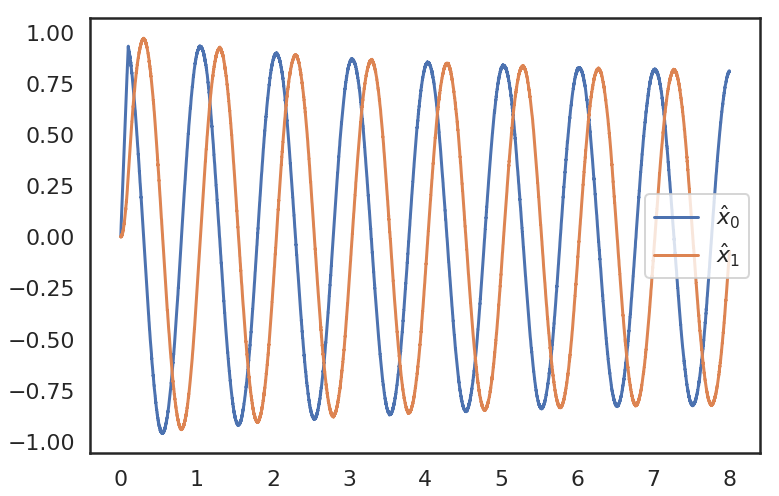

In [77]:
go_default(max_rates=Uniform(200, 400))

### low rates, LIF

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

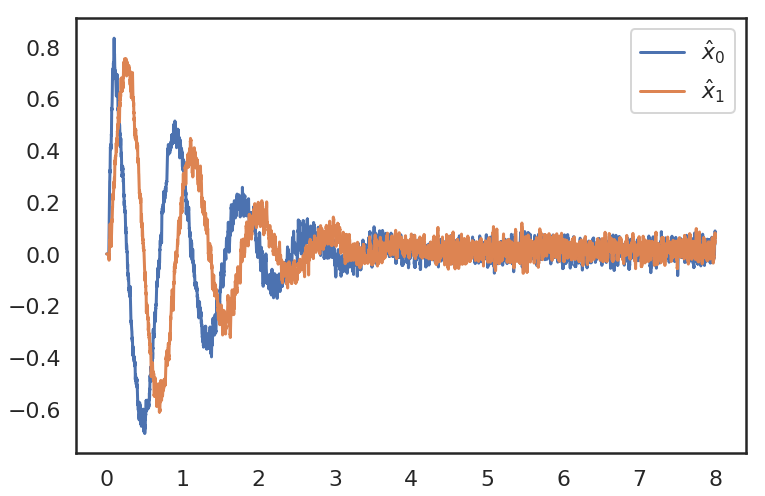

In [78]:
go_default(max_rates=Uniform(20, 40))

fewer neurons actually does better...

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

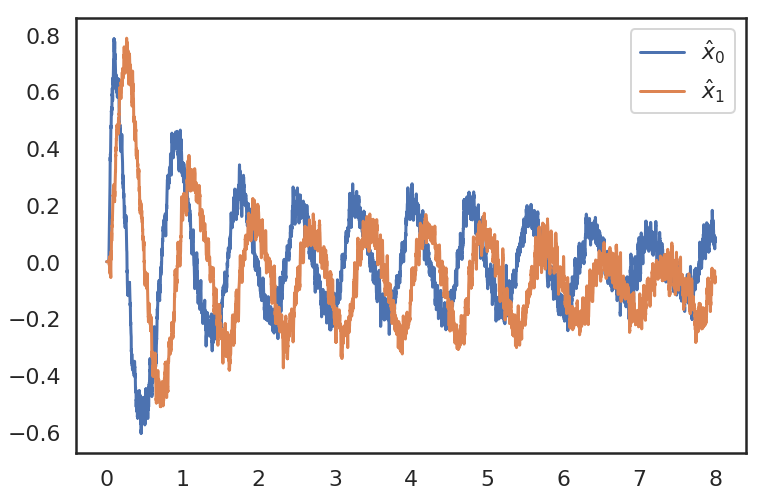

In [79]:
go_default(n_neurons=200, max_rates=Uniform(20, 40))

### low rates, spiking ReLu

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

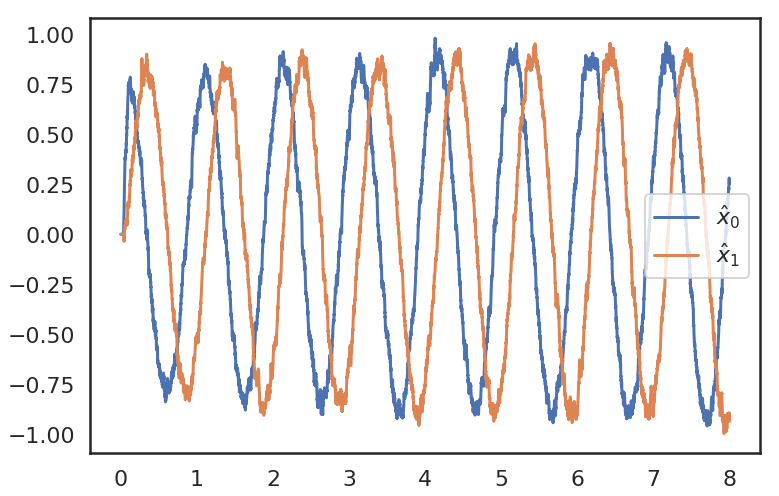

In [80]:
go_default(max_rates=Uniform(20, 40), neuron_type=nengo.SpikingRectifiedLinear())

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

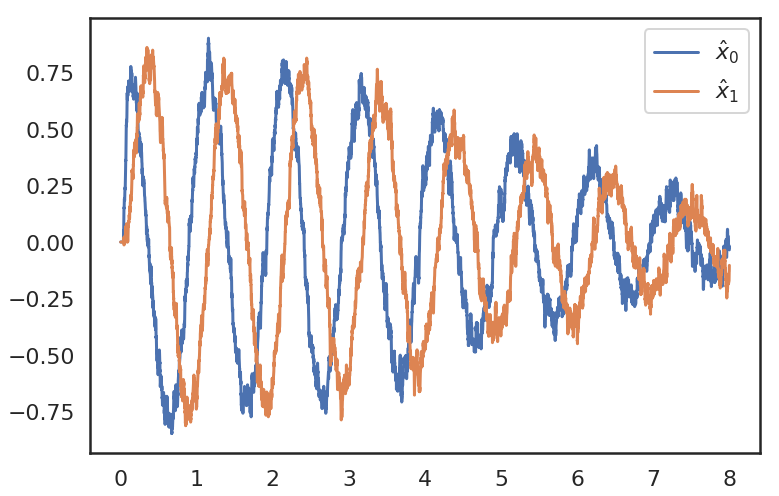

In [81]:
go_default(n_neurons=200, max_rates=Uniform(20, 40), neuron_type=nengo.SpikingRectifiedLinear())

### Distributing initial voltages doesn't immediately solve the problem

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

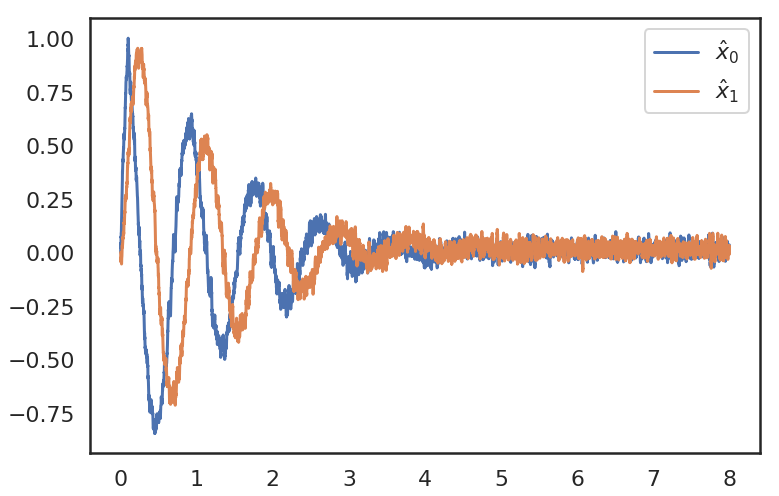

In [118]:
go_default(max_rates=Uniform(20, 40), distribute_lif=True)

## Oscillator with target values computed in math

In [119]:
def go_oscillator(n_neurons=300, t=8, freq=1, tau=0.1, dt=1e-3, k_kick=-1, t_kick=0.5, max_rates=Default):
    
    w = 2*np.pi*freq
    A = [[0, -w], [w, 0]]
    B = [[1], [0]]
    C = [[1, 0]]
    D = [[0]]
    A_ens = [[1, 0], [0, 1]] + tau*np.array(A)
    
    sys = LinearSystem((A, B, C, D))
    msys = ss2sim(sys, synapse=~s, dt=dt)
    
    def kick_gate(x):
        return x[:2] * (x[2] != k_kick)
    
    with nengo.Network(seed=0) as model:
        # nodes
        kick_ens = nengo.Node(lambda t: k_kick if t<=t_kick else 0)
        kick_tar = nengo.Node(lambda t: 1/dt if t<=dt else 0)
        fb_gate_lif = nengo.Ensemble(1, 3, neuron_type=nengo.Direct())
        # ensembles
        lif = nengo.Ensemble(n_neurons, 2, neuron_type=nengo.LIF(), max_rates=max_rates, radius=np.sqrt(2))
        tar = nengo.Ensemble(1, 2, neuron_type=Direct())
        # kick connections
        nengo.Connection(kick_ens, lif, synapse=None, transform=msys.B)
        nengo.Connection(kick_tar, tar, synapse=~s, transform=msys.B)
        nengo.Connection(kick_ens, fb_gate_lif[2], synapse=None)
        # feedback connections
        nengo.Connection(lif, fb_gate_lif[:2], synapse=tau, transform=A_ens)
        nengo.Connection(fb_gate_lif, lif, synapse=None, function=kick_gate)
#         nengo.Connection(lif, lif, synapse=tau, transform=A_ens)
        nengo.Connection(tar, tar, synapse=~s, transform=msys.A)
        p_lif = nengo.Probe(lif, synapse=tau)
        p_tar = nengo.Probe(tar, synapse=None)
        
    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        sim.run(t)
        
    fig, ax = plt.subplots(figsize=((12, 8)))
    ax.plot(sim.trange(), sim.data[p_lif][:,0], label='$\hat{x}_0$')
    ax.plot(sim.trange(), sim.data[p_lif][:,1], label='$\hat{x}_1$')
    ax.plot(sim.trange(), sim.data[p_tar][:,0], label='$x_0$')
    ax.plot(sim.trange(), sim.data[p_tar][:,1], label='$x_1$')
    plt.legend()
    plt.show()

### confirm estimates align with targets (i.e. make sure kick and nodes are working as intended)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

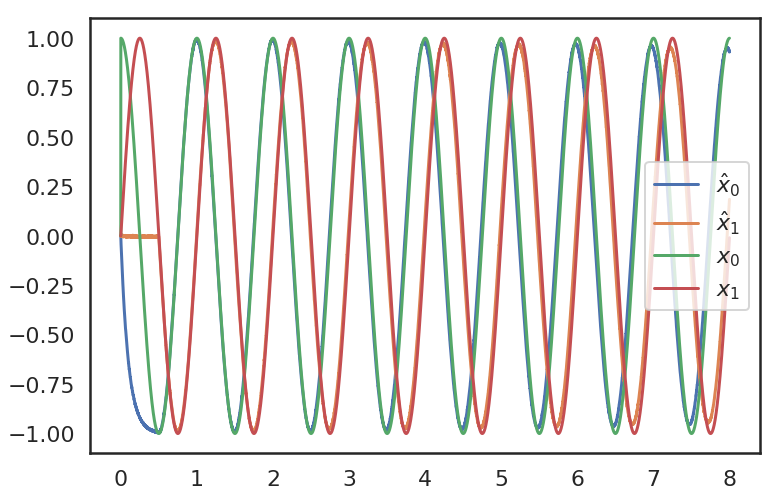

In [120]:
go_oscillator()

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

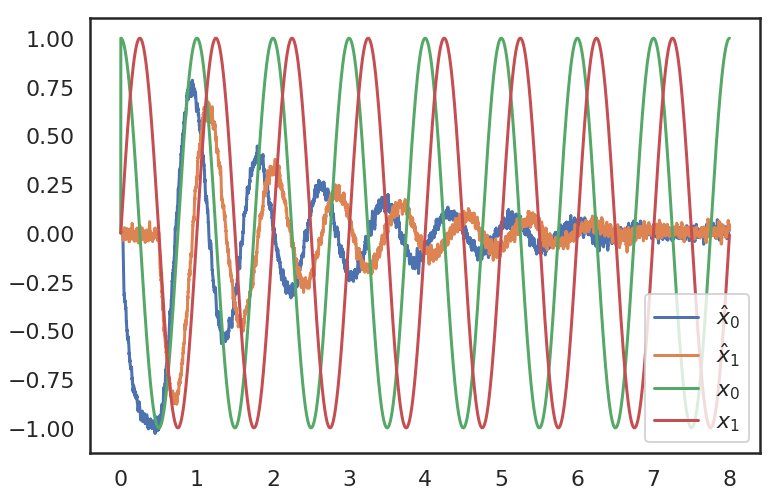

In [121]:
go_oscillator(max_rates=Uniform(20, 40))

## Oscillator with decoders and filters optimized to match target

In [88]:
def update_h_hyperopt(target, spikes, order=1, maxiter=100, seed=0, dt=0.001,
        tau_mins=[0.05, 0.001], tau_maxs=[0.2, 0.01], reg_min=1e-1, reg_max=1e-1):

    np.savez('spk.npz', spikes=spikes)
    np.savez('tar.npz', target=target)
    
    hyperparams = {}
    hyperparams['order'] = order
    hyperparams['dt'] = dt
    for o in range(order):
        hyperparams[str(o)] = hp.uniform(str(o), tau_mins[o], tau_maxs[0])
#     hyperparams['reg'] = hp.uniform('reg', reg_min, reg_max)
    hyperparams['reg'] = reg_min

    def objective(hyperparams):
        if hyperparams['order'] == 1:
            taus = [hyperparams['0']]
            h = Lowpass(taus[0])
        elif hyperparams['order'] == 2:
            taus = [hyperparams['0'], hyperparams['1']]
            h = DoubleExp(taus[0], taus[1])
        reg = hyperparams['reg']
        spk = np.load('spk.npz')['spikes']
        act = h.filt(spk, dt=hyperparams['dt'])
        tar = np.load('tar.npz')['target']
        d = LstsqL2(reg=reg)(act, tar)[0]
        xhat = np.dot(act, d)
        loss = nrmse(xhat, target=tar)
        return {'loss': loss, 'taus': taus, 'reg': reg, 'status': STATUS_OK }
    
    trials = Trials()

    fmin(objective,
        rstate=np.random.RandomState(seed=seed),
        space=hyperparams,
        algo=tpe.suggest,
        max_evals=maxiter,
        trials=trials)
    best_idx = np.argmin(trials.losses())
    best = trials.trials[best_idx]

    if order == 1:
        h_new = Lowpass(best['result']['taus'][0])
    elif order == 2:
        h_new = DoubleExp(best['result']['taus'][0], best['result']['taus'][1])
    d_new = LstsqL2(reg=best['result']['reg'])(h_new.filt(spikes, dt=dt), target)[0]
        
    return d_new, h_new

In [102]:
def go_oracle_h(d, h, n_neurons=300, t=8, n_neurons_pre=300, neuron_type=nengo.LIF(),
        max_rates=Default, intercepts=Default, supv=1, order=1, pf=True,
        reg=0.1, freq=1, tau=0.1, dt=1e-3, k_kick=-1, k_damp=-1, t_kick=0.5):
    
    w = 2*np.pi*freq
    A = [[0, -w], [w, 0]]
    B = [[1], [0]]
    C = [[1, 0]]
    D = [[0]]
    A_ens = [[1, 0], [0, 1]] + tau*np.array(A)
    
    sys = LinearSystem((A, B, C, D))
    msys = ss2sim(sys, synapse=~s, dt=dt)
    
    with nengo.Network(seed=0) as model:
        # nodes
        kick_pre_u = nengo.Node(lambda t: k_kick if t<=t_kick else 0)
        damp_pre_u = nengo.Node(lambda t: k_damp if t>t_kick else 0)
        damp_pre_x = nengo.Node(lambda t: k_damp if t<t_kick else 0)
        kick_tar = nengo.Node(lambda t: 1/dt if t<=dt else 0)
        # ensembles
        pre_u = nengo.Ensemble(n_neurons_pre, 2, neuron_type=nengo.LIF(),
               max_rates=max_rates, intercepts=intercepts, radius=np.sqrt(2))
        pre_x = nengo.Ensemble(n_neurons_pre, 2, neuron_type=nengo.LIF(),
                max_rates=max_rates, intercepts=intercepts, radius=np.sqrt(2))
        ens = nengo.Ensemble(n_neurons, 2, neuron_type=neuron_type,
            max_rates=max_rates, intercepts=intercepts, radius=np.sqrt(2))
        tar = nengo.Ensemble(1, 2, neuron_type=Direct())
        # supervisor connections
        nengo.Connection(kick_pre_u, pre_u, synapse=None, transform=msys.B)
        nengo.Connection(damp_pre_u, pre_u.neurons, synapse=None, transform=np.ones((n_neurons_pre, 1)))
        nengo.Connection(kick_tar, tar, synapse=~s, transform=msys.B)
        nengo.Connection(tar, tar, synapse=~s, transform=msys.A)
        nengo.Connection(tar, pre_x, synapse=None)
        nengo.Connection(damp_pre_x, pre_x.neurons, synapse=None, transform=np.ones((n_neurons_pre, 1)))
        if supv:
            nengo.Connection(pre_u, ens, synapse=tau)
            nengo.Connection(pre_x, ens, synapse=tau)
        else:
            nengo.Connection(pre_u, ens, synapse=h)
            nengo.Connection(ens, ens, synapse=h, solver=NoSolver(d))            
        # probes
        p_pre_u = nengo.Probe(pre_u, synapse=tau)
        p_pre_x = nengo.Probe(pre_x, synapse=tau)
        p_spk = nengo.Probe(ens.neurons, synapse=None)
        p_tar = nengo.Probe(tar, synapse=None)
        
    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        sim.run(t)
    

    if supv:
        d, h = update_h_hyperopt(
            Lowpass(tau).filt(sim.data[p_tar][int(t_kick/dt):], dt=dt),
            sim.data[p_spk][int(t_kick/dt):],
            order=order, dt=dt)
    if pf:
        times = np.arange(0, 1, 0.0001)
        y_tar = Lowpass(0.1).impulse(len(times), dt=0.0001)
        y = h.impulse(len(times), dt=0.0001)
        fig, ax = plt.subplots(figsize=((12, 8)))
        ax.plot(times, y_tar, label="h_tar")
        ax.plot(times, y, label="h")
        ax.set(xlabel='time (seconds)', ylabel='impulse response', ylim=((0, 10)))
        ax.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
        
    a_ens = h.filt(sim.data[p_spk][int(t_kick/dt):], dt=dt)
    tar = Lowpass(tau).filt(sim.data[p_tar][int(t_kick/dt):], dt=dt)
    times = sim.trange(sample_every=dt)[int(t_kick/dt):]
    xhat = np.dot(a_ens, d)
    
    fig, ax = plt.subplots(figsize=((12, 8)))
    ax.plot(times, xhat[:,0], label='$\hat{x}_0$')
    ax.plot(times, xhat[:,1], label='$\hat{x}_1$')
    ax.plot(times, tar[:,0], label='$x_0$')
    ax.plot(times, tar[:,1], label='$x_1$')
    ax.set(title='supervised = %s'%(supv==1))
    plt.legend()
    plt.show()
    
    return d, h

## high rates

In [103]:
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

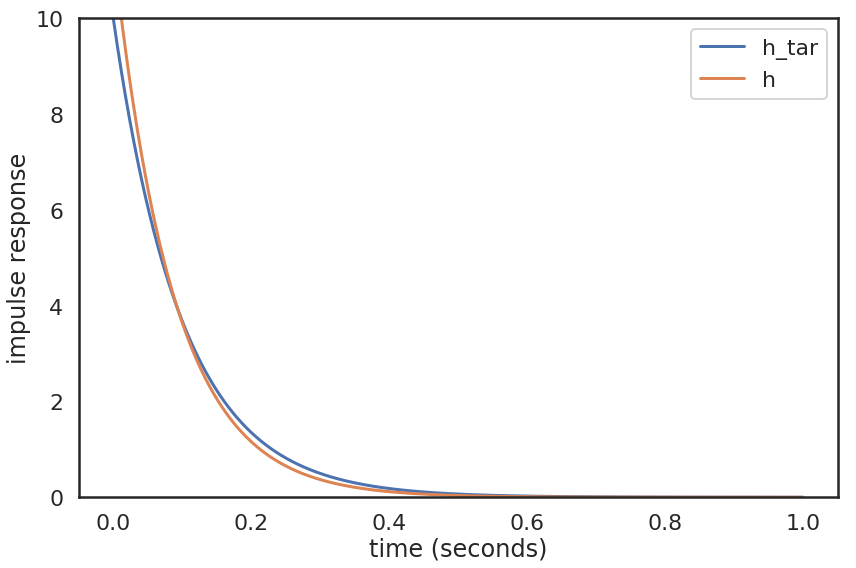

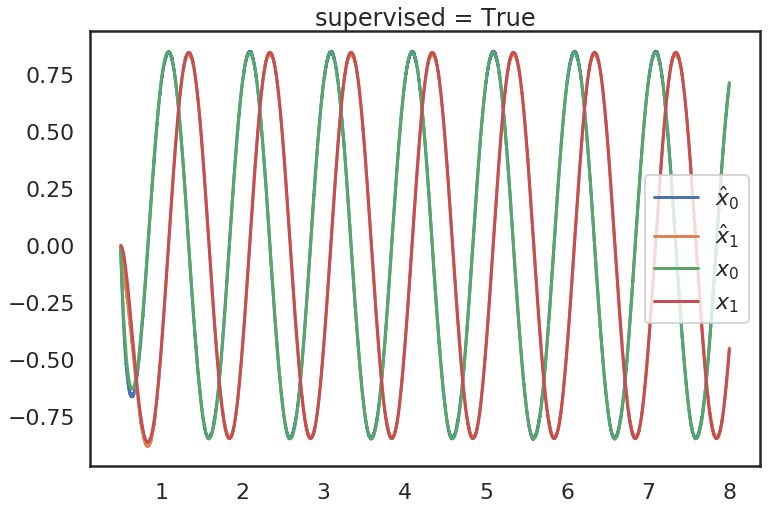

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

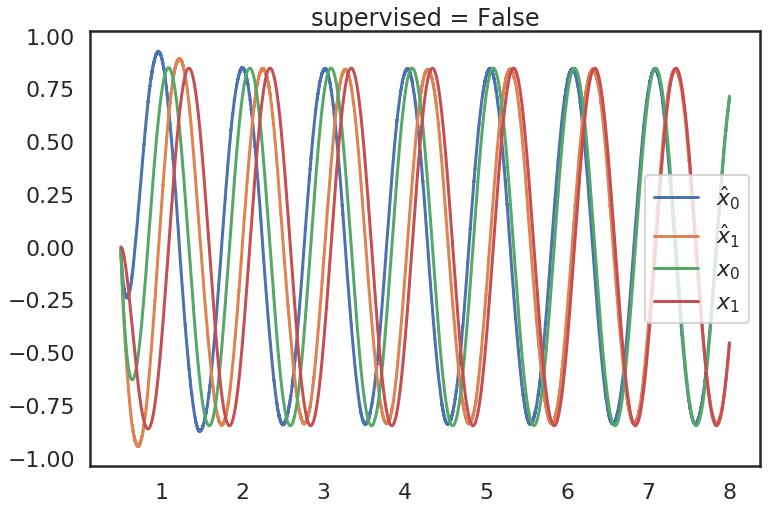

In [104]:
nt = nengo.LIF()

d, h = go_oracle_h(d_init, h_init, neuron_type=nt, supv=1)

_, _ = go_oracle_h(d, h, neuron_type=nt, supv=0, pf=False)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

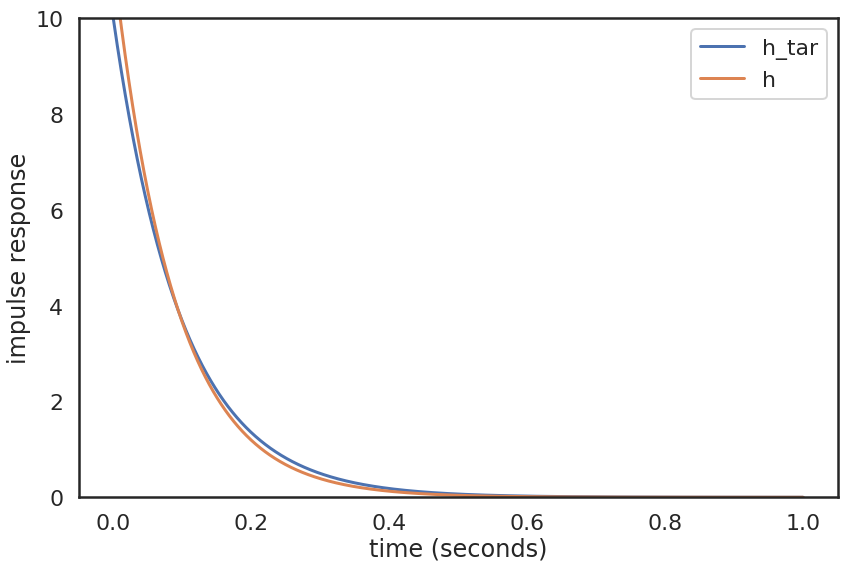

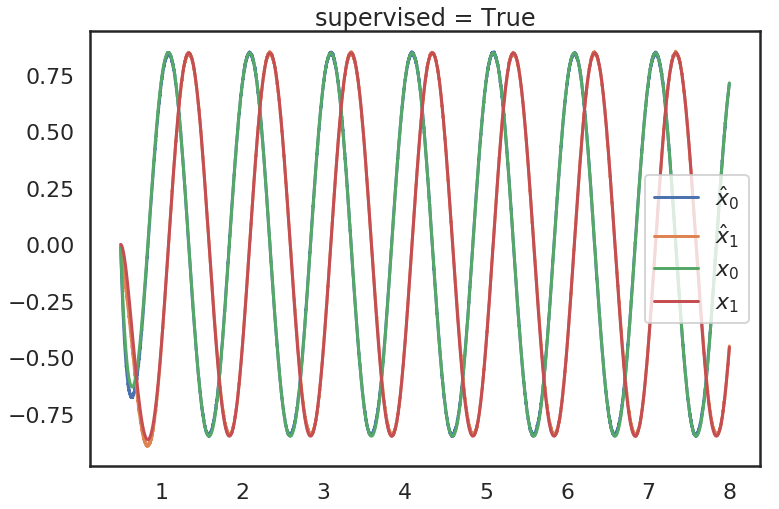

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

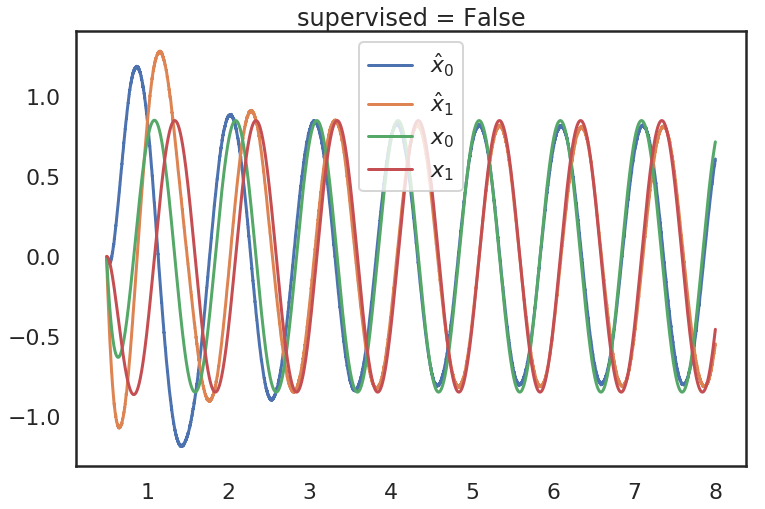

In [105]:
nt = nengo.SpikingRectifiedLinear()

d, h = go_oracle_h(d_init, h_init, neuron_type=nt, supv=1)

_, _ = go_oracle_h(d, h, neuron_type=nt, supv=0, pf=False)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

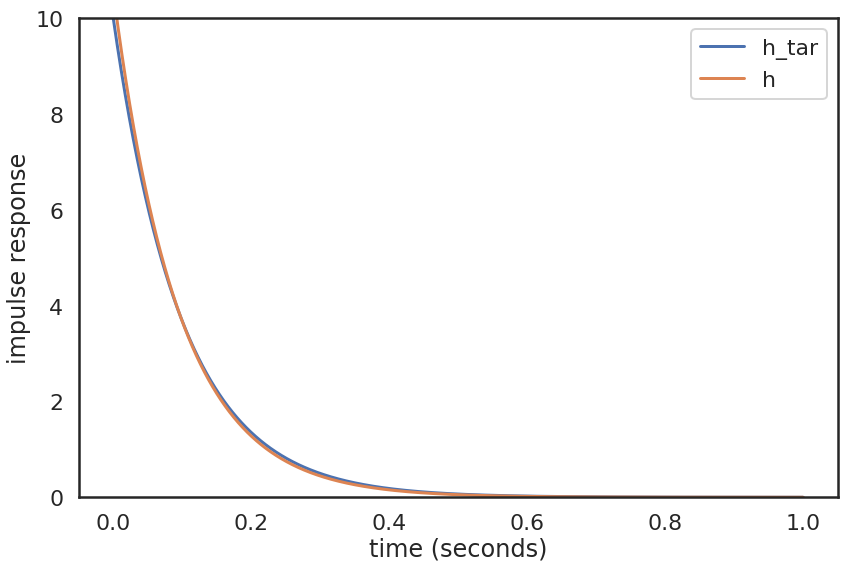

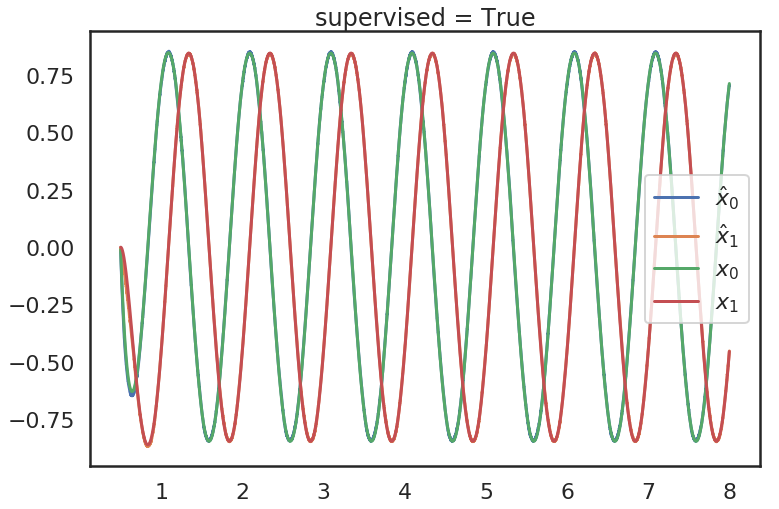

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

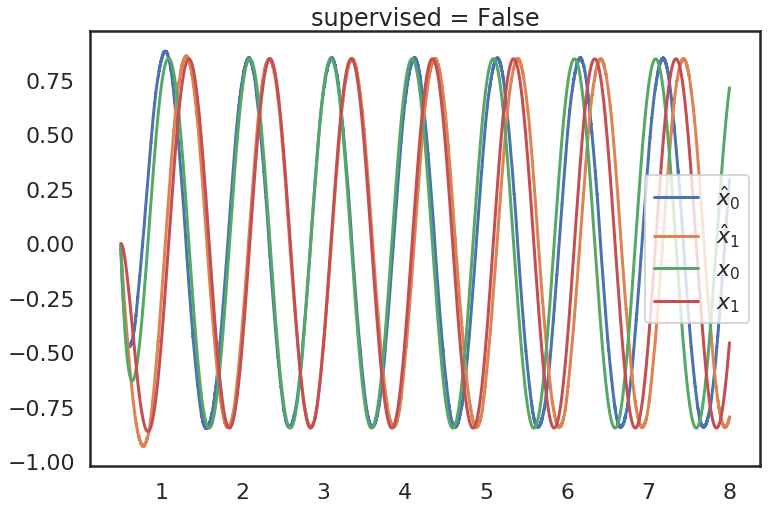

In [106]:
nt = AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1)

d, h = go_oracle_h(d_init, h_init, neuron_type=nt, supv=1)

_, _ = go_oracle_h(d, h, neuron_type=nt, supv=0, pf=False)

## Low rates

each neuron type has a 'characteristic' oscillating frequency w > w_target that it falls into

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

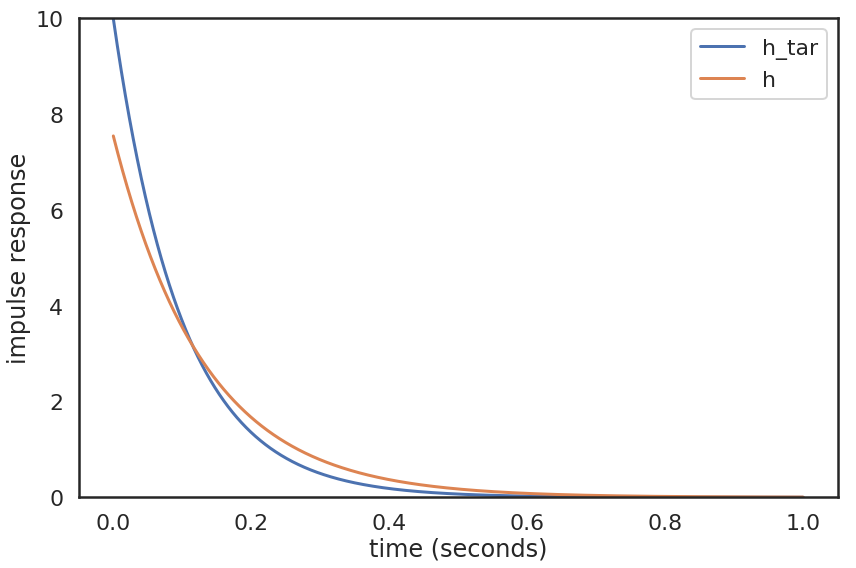

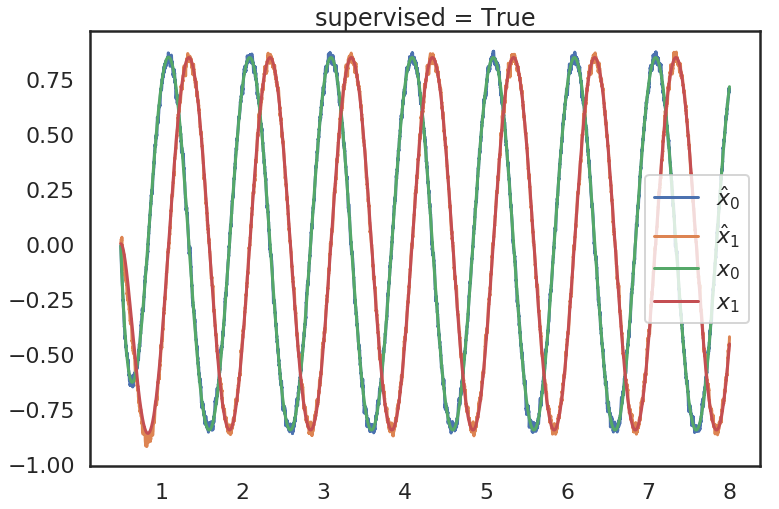

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

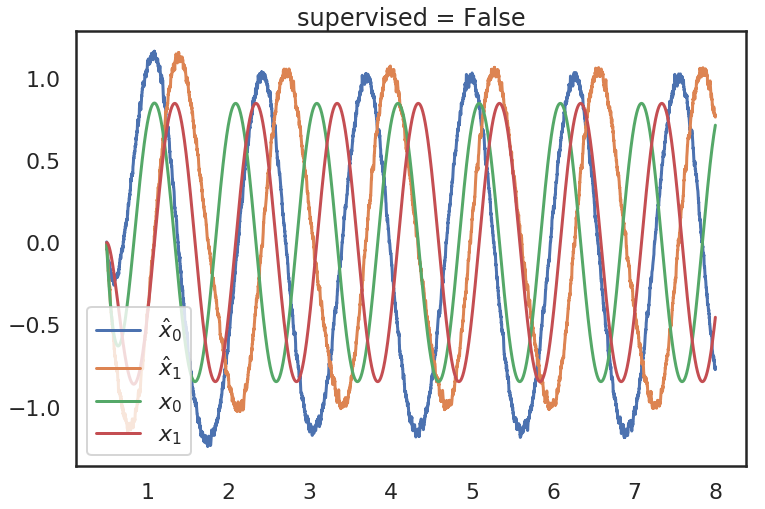

In [107]:
nt = nengo.LIF()
max_rates = Uniform(20, 40)

d, h = go_oracle_h(d_init, h_init, neuron_type=nt, supv=1, max_rates=max_rates)

_, _ = go_oracle_h(d, h, neuron_type=nt, supv=0, max_rates=max_rates, pf=False)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

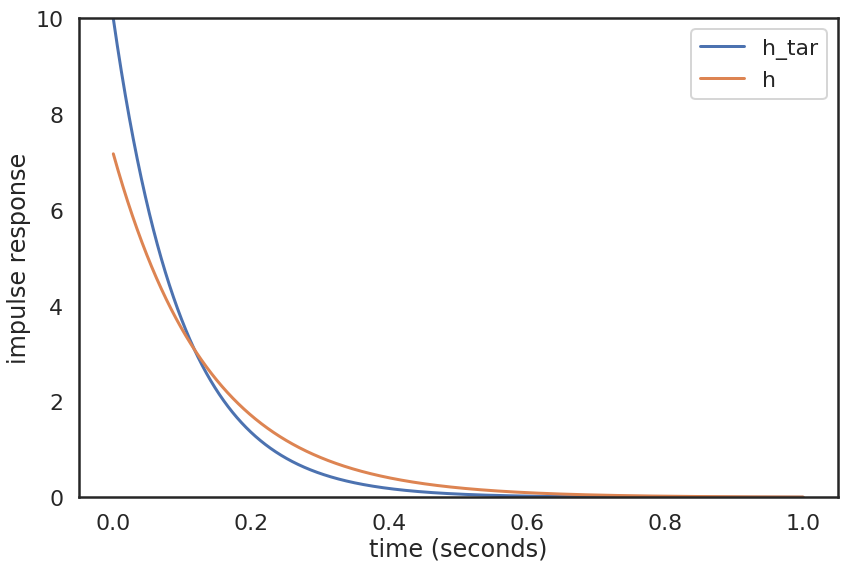

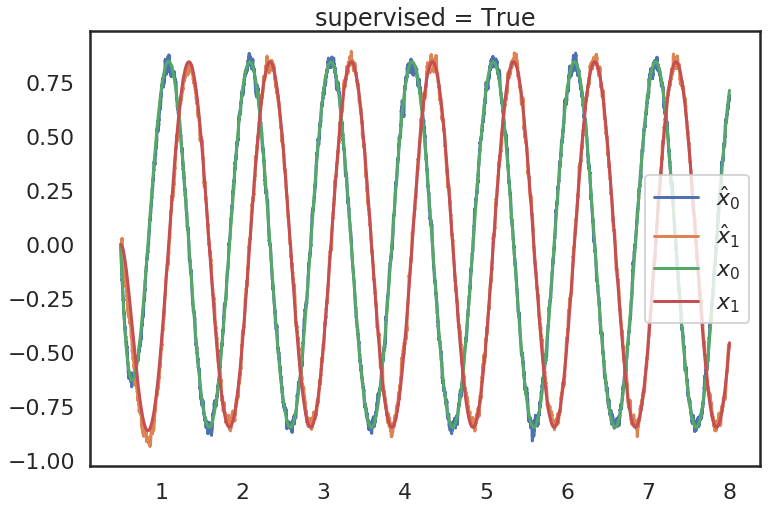

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

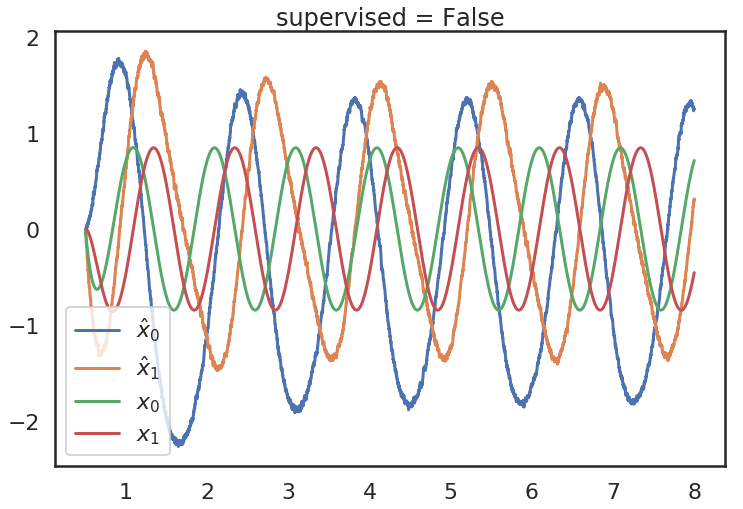

In [108]:
nt = nengo.SpikingRectifiedLinear()
max_rates = Uniform(20, 40)

d, h = go_oracle_h(d_init, h_init, neuron_type=nt, supv=1, max_rates=max_rates)

_, _ = go_oracle_h(d, h, neuron_type=nt, supv=0, max_rates=max_rates, pf=False)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

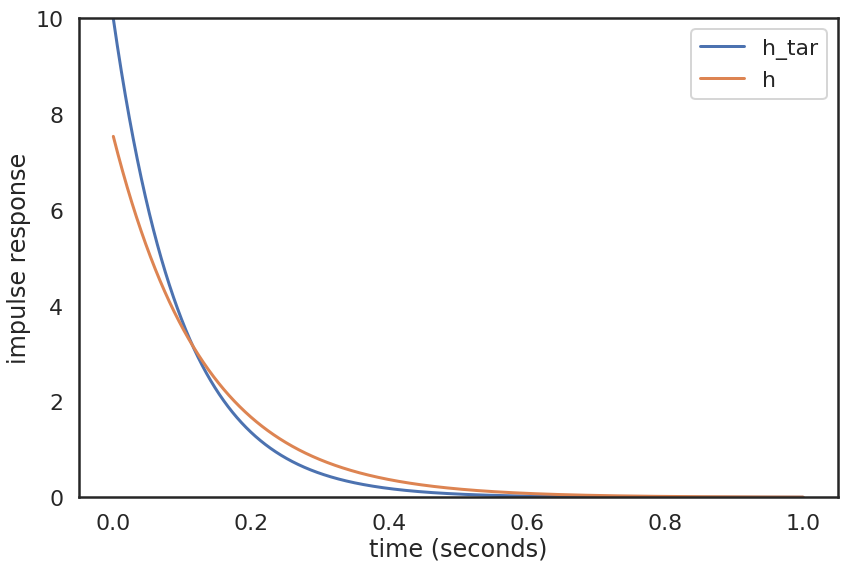

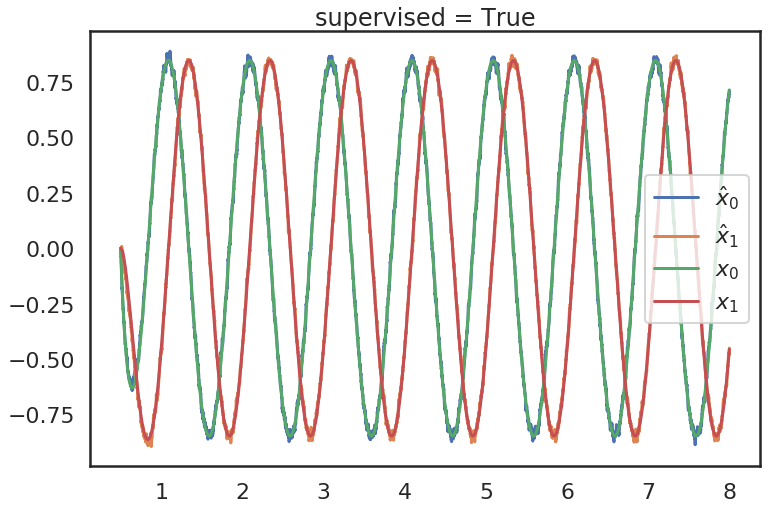

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

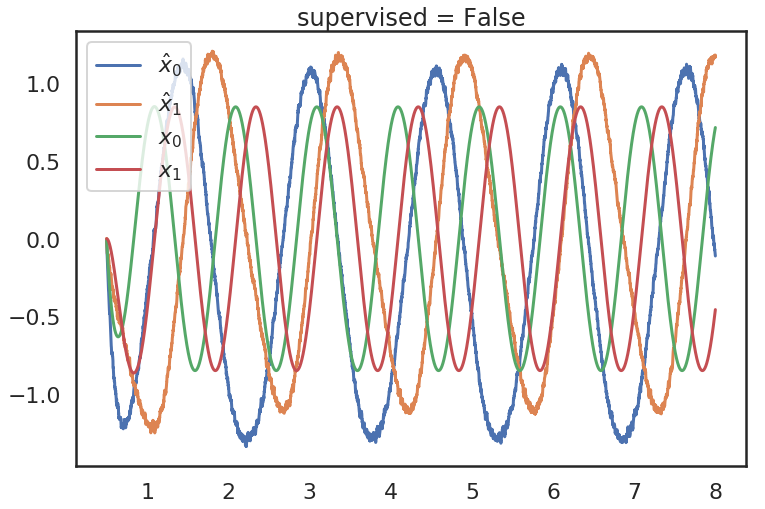

In [109]:
nt = AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1)
max_rates = Uniform(20, 40)

d, h = go_oracle_h(d_init, h_init, neuron_type=nt, supv=1, max_rates=max_rates)

_, _ = go_oracle_h(d, h, neuron_type=nt, supv=0, max_rates=max_rates, pf=False)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

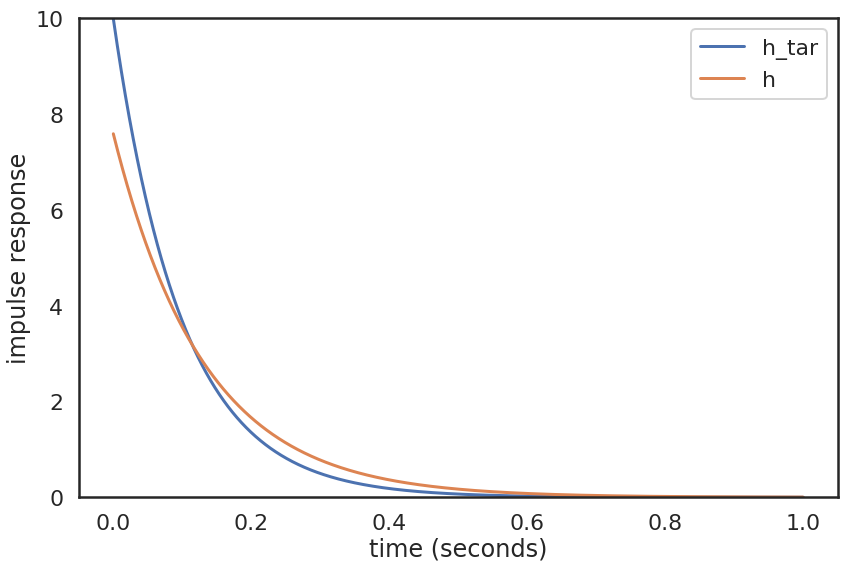

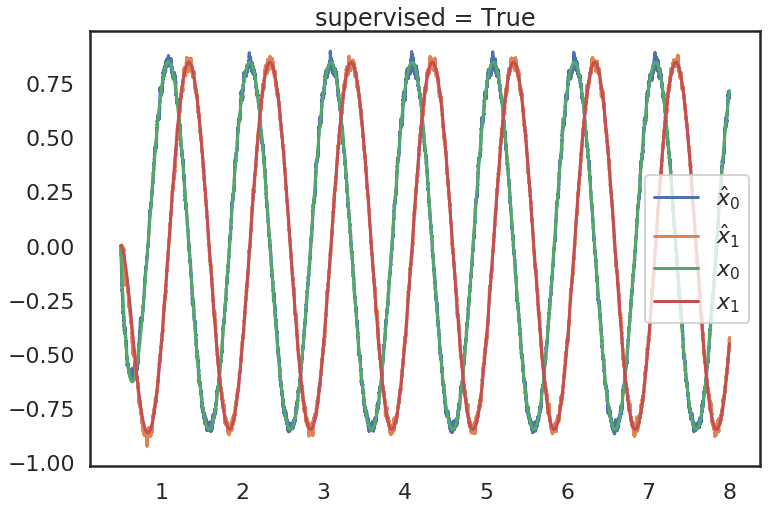

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

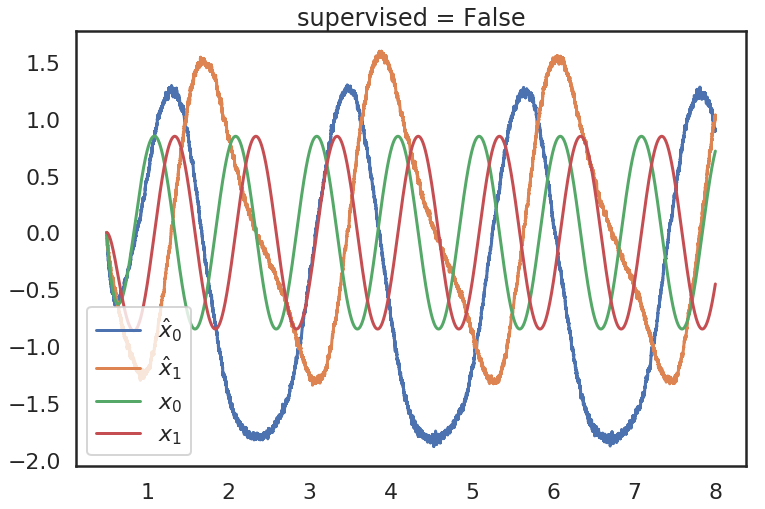

In [110]:
dt = 0.000025
nt = WilsonEuler()
max_rates = Uniform(20, 40)

d, h = go_oracle_h(d_init, h_init, neuron_type=nt, supv=1, dt=dt, max_rates=max_rates)

_, _ = go_oracle_h(d, h, neuron_type=nt, supv=0, dt=dt, max_rates=max_rates, pf=False)